##**관심데이터 선정**<br>
<img src="https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/e68e5312-d465-4641-bfa6-53da7b7e78b9/%EB%B2%A0%EC%9D%B4%ED%8D%BC%ED%94%8C%EB%9D%BC%EC%9D%B4-2-%EB%82%A8%EC%84%B1-%EB%A1%9C%EB%93%9C-%EB%A0%88%EC%9D%B4%EC%8B%B1%ED%99%94-0i5BScKF.png" width="300px;"/><br>

온라인 쇼핑에서 물건에 대한 Tag를 달다둔다. 하지만 이를 잘 못 표기해 둬 사람들이 구매하는데 오히려 방해가 될 수 있고 데이터 분석을 하는데 방해가 될 수 있다. 따라서 사람들이 파는 상품의 이미지를 인식하여 Tag를 자동적으로 해주는 모델을 만들려고 한다.

# Load in Data

In [38]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
dir = "/content/drive/MyDrive/Colab Notebooks/data/shoes"

In [40]:
train_dir = dir + '/train'
test_dir = dir + '/test'
sample_img = train_dir + '/adidas/100.jpg'

In [41]:
from PIL import Image
img = Image.open(sample_img)
print(f'Image dimensions: {img.mode} {img.size}')

Image dimensions: RGB (240, 240)


# Data Split

In [42]:
from tensorflow.keras.preprocessing import image_dataset_from_directory # Generates a tf.data.Dataset from image files in a directory.

In [43]:
def get_ds(ds, ds_dir, batch, image, color, v_split = None, subset = None):
    print('\n', ds, ':')
    return image_dataset_from_directory(ds_dir, batch_size = batch, image_size = image,
                                        color_mode = color, validation_split = v_split,
                                        subset = subset, seed = 0)

In [44]:
batch = 16
v_split = .2
train_ds = get_ds('Training', train_dir, batch, img.size, img.mode.lower(), v_split, 'training')
valid_ds = get_ds('Validation', train_dir, batch, img.size, img.mode.lower(), v_split, 'validation')
test_ds = get_ds('Testing', test_dir, batch, img.size, img.mode.lower())


 Training :
Found 711 files belonging to 3 classes.
Using 569 files for training.

 Validation :
Found 711 files belonging to 3 classes.
Using 142 files for validation.

 Testing :
Found 114 files belonging to 3 classes.


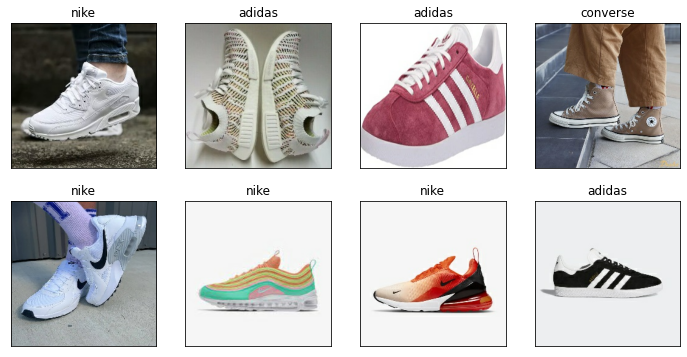

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize = (12, 6))

for images, labels in train_ds.take(1):
     for i in range(2):
        for j in range(4):
            index = i*4+j
            ax[i][j].imshow(images[index].numpy().astype("uint8")) # 이미지, uint8(양수만 표현 가능, 2^8개수 만큼 표현이 가능)
            ax[i][j].set_title(train_ds.class_names[labels[index]]) # 라벨
            ax[i][j].set(xticks=[], yticks=[]) # 축 눈금 없애기

In [46]:
# 데이터가 소비되는 시간과 데이터가 생성되는 시간 간의 의존성을 줄인다.
from tensorflow.data import AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
datasets = (train_ds, valid_ds, test_ds)

In [47]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential, layers, applications

In [48]:
def get_clf(clf_name):
    
    base_clf = None
    
    input_shape = (240, 240, 3)
    inputs = Input(shape = input_shape)
    
    data_augmentation = Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(.2),
        layers.RandomZoom(.2)
    ])

    scaling = Sequential([layers.Rescaling(scale = 1./255)])
    
    head = Sequential([layers.Flatten(), layers.Dense(units = 3, activation = 'softmax')])

    if clf_name == 'naive_clf':
        x = inputs
    
    elif clf_name == 'simple_clf':
        x = data_augmentation(inputs)
        x = scaling(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
  
    elif clf_name == 'Xception_clf':
        # Xception 은 구글이 2017년에 발표한 모델로, 2015년에 ILSVRC 대회에서 2등을 한 Google 의 Inception-V3 모델보다 훨씬 좋은 결과를 냈다.
        base_clf = applications.Xception(include_top = False, input_shape = input_shape)
        base_clf.trainable = False
        
        x = data_augmentation(inputs)
        x = scaling(x)
        x = base_clf(x, training = False)
        x = layers.MaxPooling2D()(x)
        
    else: assert(False)
    
    outputs = head(x)
    clf = Model(inputs, outputs, name = clf_name)
    
    clf.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy']
    )
    
    return base_clf, clf

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_result(ax, df, column_list, st = 10):
    data = df[column_list].loc[st:,:].melt(ignore_index=False).rename_axis('epoch').reset_index()
    sns.lineplot(ax = ax, data = data, x = 'epoch', y = 'value', hue = 'variable')

def fit_and_evaluate(clf_name, datasets, epochs):
    
    # fit model
    base_clf, clf = get_clf(clf_name)
    train_ds, valid_ds, test_ds = datasets
    results = clf.fit(train_ds, epochs = epochs, verbose = 0, validation_data = valid_ds)
    
    # print test results
    test_loss, test_accuracy = clf.evaluate(test_ds, verbose = 0)
    print('{} test accuracy: {:.0%}'.format(clf_name, test_accuracy))
    
    # plot fitting history
    fig, ax = plt.subplots(1, 2, figsize = (12, 3))
    res_df = pd.DataFrame(results.history)
    plot_result(ax[0], res_df, ['loss', 'val_loss'])
    plot_result(ax[1], res_df, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
    
    return base_clf, clf

naive_clf test accuracy: 49%


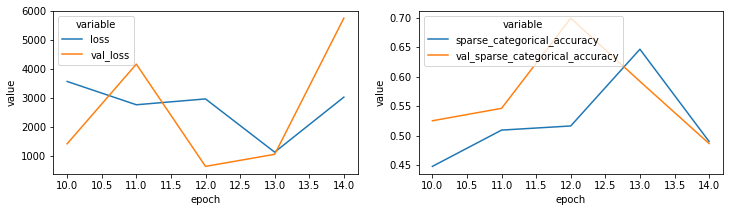

In [50]:
__, clf = fit_and_evaluate('naive_clf', datasets, epochs = 15)

simple_clf test accuracy: 40%


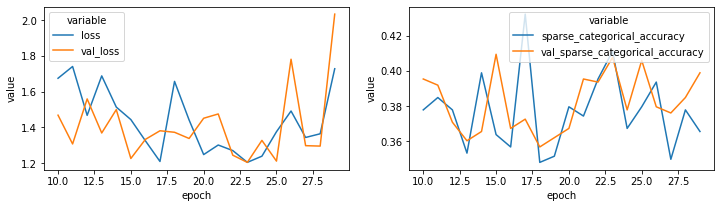

In [51]:
__, clf = fit_and_evaluate('simple_clf', datasets, epochs = 30)

83683744/83683744 [==============================] - 0s 0us/step
Xception_clf test accuracy: 93%


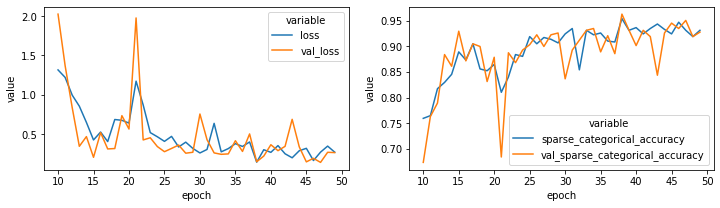

In [52]:
base_clf, clf = fit_and_evaluate('Xception_clf', datasets, epochs = 50)